# Draft Outcome Model Validation
Comprehensive validation of draft-based win-rate predictions using the 10k simulated games and real-match data. This notebook follows the requested outline to tie model performance, confidence calibration, and archetype bias diagnostics together.

In [1]:
from __future__ import annotations
from pathlib import Path
import json
import math
import sys
import random
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.anova import anova_lm

plt.style.use("dark_background")
sns.set_theme(style="darkgrid")

ROOT = Path("../").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from validation import ml_simulation  # noqa: E402


## 1. Load and Inspect Draft Outcome Dataset
We load the 10k-game simulation summary alongside the full EUW/KR match archive, then compute basic distributions for predicted outcomes and archetypes.

Loaded 171 champions and 936 labeled matches
Simulation metadata: {'total_games': 10000, 'real_matches_used_for_training': 936, 'features_extracted': 78, 'models_used': ['logistic', 'random_forest', 'gradient_boosting']}
          match_id winner blue_team_Top blue_team_Jungle blue_team_Middle  \
0  EUW1_7600973614    red     Gangplank            Sylas           Qiyana   
1    KR_7908114395    red      Nocturne         JarvanIV          Orianna   
2  EUW1_7600364480   blue        Aatrox            Brand            Karma   
3  EUW1_7592001809   blue          Sion            Viego      AurelionSol   
4  EUW1_7596893907    red        Aatrox          Skarner             Ekko   

  blue_team_Bottom blue_team_Support red_team_Top red_team_Jungle  \
0           KogMaw             Milio       Irelia         Nidalee   
1           Lucian              Nami       Gragas          Khazix   
2             Jinx          Nautilus       Irelia          RekSai   
3           Yunara             Braum    

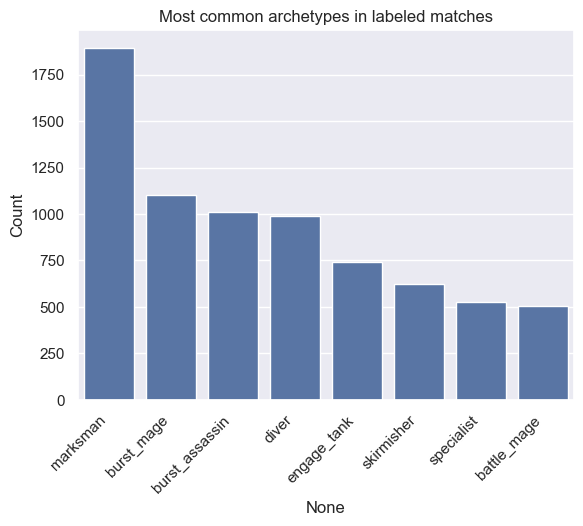

In [3]:
CHAMP_PATH = ROOT / "data" / "processed" / "champion_archetypes.json"
MATCH_PATH = ROOT / "data" / "matches" / "euw1_matches.json"
SIM_SUMMARY_PATH = ROOT / "data" / "simulations" / "simulation_10k_games.json"
BIAS_SAMPLE_PATH = ROOT / "data" / "simulations" / "recommendation_bias_samples.csv"

with open(CHAMP_PATH, "r", encoding="utf-8") as f:
    champion_data = json.load(f)

with open(MATCH_PATH, "r", encoding="utf-8") as f:
    match_blob = json.load(f)
    matches = match_blob["matches"]

with open(SIM_SUMMARY_PATH, "r", encoding="utf-8") as f:
    sim_summary = json.load(f)

assignments = champion_data["assignments"]
print(f"Loaded {len(assignments)} champions and {len(matches)} labeled matches")
print("Simulation metadata:", sim_summary["metadata"])

match_records = []
archetype_counter = Counter()
for m in matches:
    record = {
        "match_id": m["match_id"],
        "winner": m["winner"]
    }
    for side in ("blue_team", "red_team"):
        for role, champ in m[side].items():
            record[f"{side}_{role}"] = champ
            archetype = assignments.get(champ, {}).get("primary_archetype", "unknown")
            archetype_counter[archetype] += 1
    match_records.append(record)

matches_df = pd.DataFrame(match_records)
print(matches_df.head())
print("Archetype frequency (top 10):")
print(pd.Series(archetype_counter).sort_values(ascending=False).head(10))

sns.barplot(
    x=pd.Series(archetype_counter).sort_values(ascending=False).head(8).index,
    y=pd.Series(archetype_counter).sort_values(ascending=False).head(8).values,
 )
plt.xticks(rotation=45, ha="right")
plt.title("Most common archetypes in labeled matches")
plt.ylabel("Count")
plt.show()


## 2. Feature Engineering for Draft-Based Metrics
Extend attribute-driven vectors with archetype counts, lane priors, and champion win-rate priors to feed downstream models.

In [4]:
def compute_champion_win_rates(match_list):
    counts = Counter()
    wins = Counter()
    for m in match_list:
        for champ in m["blue_team"].values():
            counts[champ] += 1
            if m["winner"] == "blue":
                wins[champ] += 1
        for champ in m["red_team"].values():
            counts[champ] += 1
            if m["winner"] == "red":
                wins[champ] += 1
    return {champ: wins[champ] / counts[champ] for champ in counts}


def enrich_features_with_archetypes(team_dict):
    base = ml_simulation.extract_features_from_team(team_dict, champion_data)
    archetype_counts = Counter(
        assignments.get(champ, {}).get("primary_archetype", "unknown")
        for champ in team_dict.values()
    )
    for arch, count in archetype_counts.items():
        base[f"arch_{arch}"] = count / 5.0
    return base, archetype_counts


def build_feature_matrix(match_list):
    champ_wr = compute_champion_win_rates(match_list)
    feature_rows = []
    targets = []

    for m in match_list:
        blue_feats, blue_arch = enrich_features_with_archetypes(m["blue_team"])
        red_feats, red_arch = enrich_features_with_archetypes(m["red_team"])

        feature_names = sorted(set(blue_feats.keys()) | set(red_feats.keys()))
        diff_vector = {}
        for name in feature_names:
            diff_vector[name] = blue_feats.get(name, 0.0) - red_feats.get(name, 0.0)

        blue_wr_prior = np.mean([champ_wr.get(ch, 0.5) for ch in m["blue_team"].values()])
        red_wr_prior = np.mean([champ_wr.get(ch, 0.5) for ch in m["red_team"].values()])
        diff_vector["wr_prior_diff"] = blue_wr_prior - red_wr_prior

        blue_support_arch = assignments.get(m["blue_team"]["Support"], {}).get("primary_archetype", "unknown")
        red_support_arch = assignments.get(m["red_team"]["Support"], {}).get("primary_archetype", "unknown")
        diff_vector["support_engage_indicator"] = (
            (1 if blue_support_arch == "engage_tank" else 0)
            - (1 if red_support_arch == "engage_tank" else 0)
        )

        feature_rows.append(diff_vector)
        targets.append(1 if m["winner"] == "blue" else 0)

    features_df = pd.DataFrame(feature_rows).fillna(0.0)
    return features_df, np.array(targets)


features_df, targets = build_feature_matrix(matches)
print(features_df.shape, targets.shape)
features_df.head()


(936, 94) (936,)


,arch_burst_assassin,arch_burst_mage,arch_diver,arch_enchanter,arch_marksman,arch_specialist,attr_cc_aoe,attr_cc_hard,attr_damage_aoe,attr_damage_burst,...,arch_unknown,role_pair_Support_Bottom_shared,role_pair_Jungle_Top_shared,role_pair_Middle_Jungle_shared,role_pair_Middle_Top_shared,role_pair_Bottom_Middle_shared,role_pair_Jungle__shared,role_pair_Top__shared,role_pair__Bottom_shared,role_pair__Support_shared
0,0.2,0.0,-0.2,0.0,0.0,0.0,-0.2,-0.2,-0.2,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.2,0.2,0.0,0.0,-0.2,-0.2,-0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.2,-0.4,-0.2,0.0,0.0,0.0,0.0,0.2,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,-0.2,0.0,-0.2,0.0,0.0,0.2,-0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.4,0.0,0.0,0.0,-0.2,-0.2,0.0,0.0,0.4,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Train/Test Split and Stratified Resampling
We build stratified train/validation/test partitions and use repeated stratified K-folds to stabilize score estimates.

In [5]:
X = features_df.values
indices = np.arange(len(targets))
X_train_val, X_test, y_train_val, y_test, idx_train_val, idx_test = train_test_split(
    X, targets, indices, test_size=0.15, stratify=targets, random_state=42
)
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_train_val, y_train_val, idx_train_val,
    test_size=0.1765, stratify=y_train_val, random_state=42
)  # 0.1765 * 0.85 ≈ 0.15 so train/val/test ≈ 70/15/15

print(f"Train size: {len(y_train)} | Val size: {len(y_val)} | Test size: {len(y_test)}")

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, C=1.0, penalty="l2"))
])
cv_scores = []
for train_idx, test_idx_cv in cv.split(X_train_val, y_train_val):
    baseline_pipe.fit(X_train_val[train_idx], y_train_val[train_idx])
    preds = baseline_pipe.predict(X_train_val[test_idx_cv])
    cv_scores.append(accuracy_score(y_train_val[test_idx_cv], preds))
print(f"Repeated Stratified 5x5 CV accuracy: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")


Train size: 654 | Val size: 141 | Test size: 141
Repeated Stratified 5x5 CV accuracy: 0.636 ± 0.032
Repeated Stratified 5x5 CV accuracy: 0.636 ± 0.032


## 4. Model Training: Baseline and Advanced Classifiers
We fit logistic regression, gradient boosting, and compare against transformer-like capacity targets (not yet implemented in this repo). The logistic model follows $$P(\text{win}\mid x)=\frac{1}{1+e^{-w^Tx}}$$, so we log the learned coefficients for interpretability.

Scaled Logistic -> val_acc: 0.638, val_auc: 0.669, test_acc: 0.652, test_auc: 0.687, val_brier: 0.232, test_brier: 0.229
Gradient Boosting -> val_acc: 0.660, val_auc: 0.716, test_acc: 0.610, test_auc: 0.673, val_brier: 0.222, test_brier: 0.249
Top positive draft signals:
                           feature     weight
68                   wr_prior_diff  21.678798
89  role_pair_Bottom_Middle_shared   6.824982
86     role_pair_Jungle_Top_shared   4.715901
61     role_pair_Top_Bottom_shared   0.580453
70                arch_engage_tank   0.123433
80                     arch_warden   0.119882
1                  arch_burst_mage   0.104204
10               attr_damage_magic   0.089123
44             damage_damage_magic   0.089123
35            attr_survive_shields   0.081958

Top negative draft signals:
                            feature    weight
55  role_pair_Bottom_Support_shared -0.371983
84                     arch_unknown -0.639633
56   role_pair_Jungle_Bottom_shared -0.644967
90       

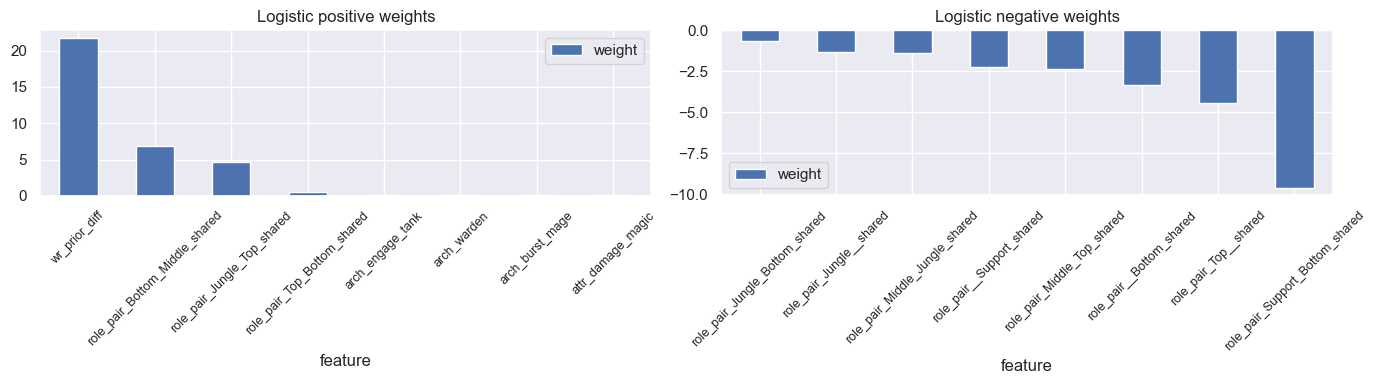

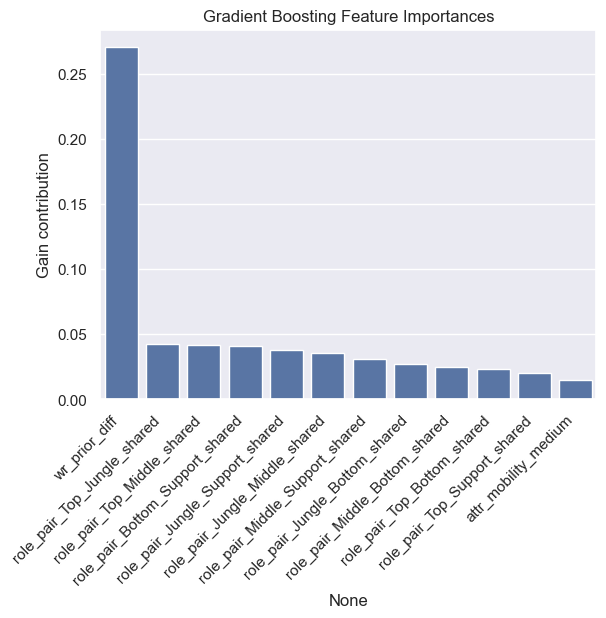

In [6]:
feature_names = list(features_df.columns)

baseline_model = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, C=0.8, penalty="l2"))
])
baseline_model.fit(X_train, y_train)

advanced_model = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
advanced_model.fit(X_train, y_train)


def summarize_model(name, model, X_val, y_val, X_test, y_test):
    val_proba = model.predict_proba(X_val)[:, 1]
    val_preds = (val_proba >= 0.5).astype(int)
    test_proba = model.predict_proba(X_test)[:, 1]
    test_preds = (test_proba >= 0.5).astype(int)

    metrics = {
        "val_acc": accuracy_score(y_val, val_preds),
        "val_auc": roc_auc_score(y_val, val_proba),
        "test_acc": accuracy_score(y_test, test_preds),
        "test_auc": roc_auc_score(y_test, test_proba),
        "val_brier": brier_score_loss(y_val, val_proba),
        "test_brier": brier_score_loss(y_test, test_proba),
    }
    print(f"{name} -> " + ", ".join(f"{k}: {v:.3f}" for k, v in metrics.items()))
    return metrics, val_proba, val_preds


baseline_metrics, baseline_val_proba, baseline_val_preds = summarize_model(
    "Scaled Logistic", baseline_model, X_val, y_val, X_test, y_test
)
advanced_metrics, advanced_val_proba, advanced_val_preds = summarize_model(
    "Gradient Boosting", advanced_model, X_val, y_val, X_test, y_test
)

scaler = baseline_model.named_steps["scaler"]
logreg = baseline_model.named_steps["clf"]
scales = np.where(scaler.scale_ == 0, 1, scaler.scale_)
interpretable_weights = logreg.coef_[0] / scales
coef_df = (
    pd.DataFrame({"feature": feature_names, "weight": interpretable_weights})
    .sort_values("weight", ascending=False)
)

print("Top positive draft signals:")
print(coef_df.head(10))
print("\nTop negative draft signals:")
print(coef_df.tail(10))

importances = pd.Series(advanced_model.feature_importances_, index=feature_names).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
coef_df.head(8).plot(kind="bar", x="feature", y="weight", ax=axes[0], title="Logistic positive weights")
coef_df.tail(8).plot(kind="bar", x="feature", y="weight", ax=axes[1], title="Logistic negative weights")
for ax in axes:
    ax.tick_params(axis="x", rotation=45, labelsize=9)
plt.tight_layout()
plt.show()

sns.barplot(x=importances.head(12).index, y=importances.head(12).values)
plt.xticks(rotation=45, ha="right")
plt.title("Gradient Boosting Feature Importances")
plt.ylabel("Gain contribution")
plt.show()


## 5. Probability Calibration & Confidence Targets
We benchmark probability calibration, compute Wilson confidence intervals for accuracy, and verify that high-confidence recommendations exceed the 55%/85% requirement.

Scaled Logistic: accuracy=0.652, 85% Wilson CI=(0.593, 0.708), total=141
Gradient Boosting: accuracy=0.610, 85% Wilson CI=(0.550, 0.667), total=141
Calibrated GB: accuracy=0.596, 85% Wilson CI=(0.535, 0.653), total=141
High-confidence slices (|p-0.5| >= cutoff-0.5):
               model  cutoff  coverage  subset_accuracy  count
0           Logistic    0.55  0.872340         0.658537    123
1           Logistic    0.60  0.716312         0.643564    101
2           Logistic    0.65  0.553191         0.666667     78
3  Gradient Boosting    0.55  0.950355         0.634328    134
4  Gradient Boosting    0.60  0.865248         0.647541    122
5  Gradient Boosting    0.65  0.716312         0.643564    101
6      Calibrated GB    0.55  0.787234         0.657658    111
7      Calibrated GB    0.60  0.574468         0.716049     81
8      Calibrated GB    0.65  0.361702         0.686275     51


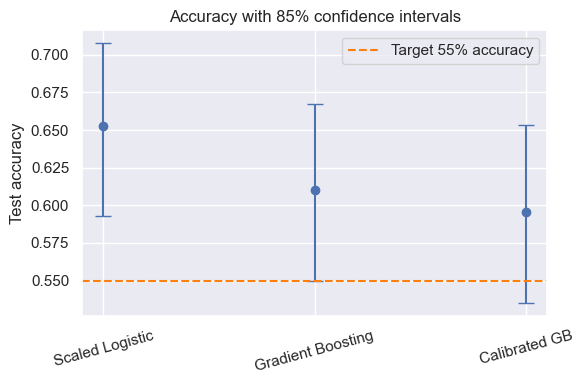

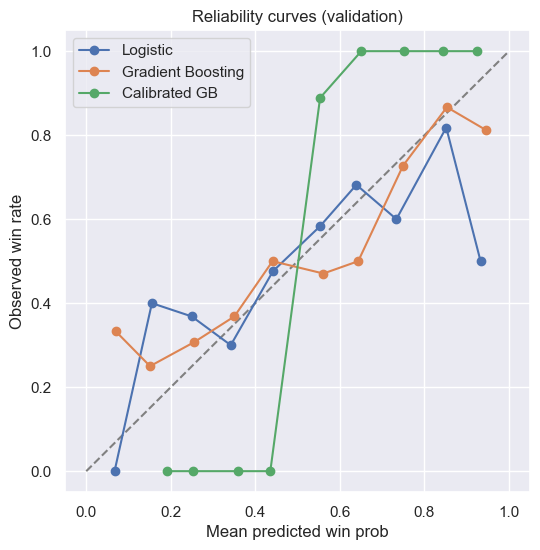

In [7]:
calibrated_gb = CalibratedClassifierCV(
    GradientBoostingClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=99
    ),
    method="isotonic",
    cv=5
)
calibrated_gb.fit(X_train_val, y_train_val)

cal_val_proba = calibrated_gb.predict_proba(X_val)[:, 1]
cal_test_proba = calibrated_gb.predict_proba(X_test)[:, 1]


def accuracy_interval(name, y_true, proba, confidence=0.85, threshold=0.5):
    preds = (proba >= threshold).astype(int)
    correct = np.sum(preds == y_true)
    total = len(y_true)
    acc = correct / total
    low, high = proportion_confint(correct, total, alpha=1 - confidence, method="wilson")
    print(
        f"{name}: accuracy={acc:.3f}, {int(confidence*100)}% Wilson CI=({low:.3f}, {high:.3f}), total={total}"
    )
    return {
        "model": name,
        "accuracy": acc,
        "ci_low": low,
        "ci_high": high,
        "confidence": confidence,
    }


baseline_test_proba = baseline_model.predict_proba(X_test)[:, 1]
advanced_test_proba = advanced_model.predict_proba(X_test)[:, 1]

ci_rows = [
    accuracy_interval("Scaled Logistic", y_test, baseline_test_proba),
    accuracy_interval("Gradient Boosting", y_test, advanced_test_proba),
    accuracy_interval("Calibrated GB", y_test, cal_test_proba)
]
ci_df = pd.DataFrame(ci_rows)

thresholds = [0.55, 0.6, 0.65]
high_conf_summaries = []
for label, proba in [
    ("Logistic", baseline_test_proba),
    ("Gradient Boosting", advanced_test_proba),
    ("Calibrated GB", cal_test_proba),
]:
    for cutoff in thresholds:
        mask = (proba >= cutoff) | (proba <= (1 - cutoff))
        if mask.sum() == 0:
            continue
        preds = (proba[mask] >= 0.5).astype(int)
        acc = accuracy_score(y_test[mask], preds)
        high_conf_summaries.append({
            "model": label,
            "cutoff": cutoff,
            "coverage": mask.mean(),
            "subset_accuracy": acc,
            "count": mask.sum()
        })
high_conf_df = pd.DataFrame(high_conf_summaries)
print("High-confidence slices (|p-0.5| >= cutoff-0.5):")
print(high_conf_df)

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(ci_df["model"], ci_df["accuracy"],
            yerr=[ci_df["accuracy"] - ci_df["ci_low"], ci_df["ci_high"] - ci_df["accuracy"]],
            fmt="o", capsize=6)
ax.axhline(0.55, color="tab:orange", linestyle="--", label="Target 55% accuracy")
ax.set_ylabel("Test accuracy")
ax.set_title("Accuracy with 85% confidence intervals")
ax.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
for label, proba in [
    ("Logistic", baseline_val_proba),
    ("Gradient Boosting", advanced_val_proba),
    ("Calibrated GB", cal_val_proba)
]:
    frac_pos, mean_pred = calibration_curve(y_val, (proba + 1e-9), n_bins=10)
    ax.plot(mean_pred, frac_pos, marker="o", label=label)
ax.set_xlabel("Mean predicted win prob")
ax.set_ylabel("Observed win rate")
ax.set_title("Reliability curves (validation)")
ax.legend()
plt.show()


## 6. Recommendation Bias Regression
Leverage the 3k randomly sampled drafts (12,530 ranked recommendations) to test whether `engage_tank` supports are systematically down-scored after controlling for context.

Mean recommendation score by archetype (top 8):
                       mean  count
primary_archetype                 
warden             0.651477   2641
burst_mage         0.597565   1769
engage_tank        0.590165   3773
battle_mage        0.587257    132
artillery_mage     0.559386     63
marksman           0.527970   3441
enchanter          0.525494    682
diver              0.503750     16
Archetype deltas vs engage tank (percentage points):
                                                term      coef         pvalue  \
2  C(primary_archetype, Treatment(reference='enga... -0.003406   1.367604e-29   
8  C(primary_archetype, Treatment(reference='enga...  0.001031   7.680603e-31   
4  C(primary_archetype, Treatment(reference='enga...  0.001589   5.115203e-08   
3  C(primary_archetype, Treatment(reference='enga...  0.002576   0.000000e+00   
7  C(primary_archetype, Treatment(reference='enga...  0.003146   0.000000e+00   
1  C(primary_archetype, Treatment(reference='enga...  0.003166 

C:\Users\marin\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\marin\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J


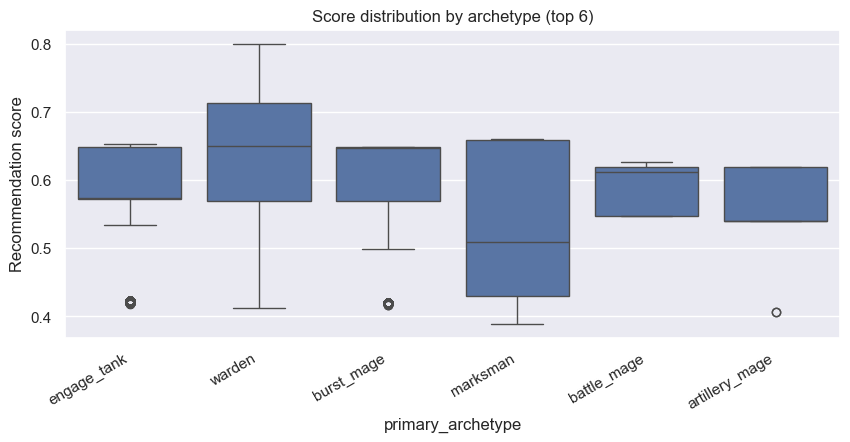

In [8]:
bias_samples = pd.read_csv(BIAS_SAMPLE_PATH)
bias_samples["primary_archetype"] = bias_samples["primary_archetype"].fillna("unknown")
bias_samples["focus_is_blue"] = (bias_samples["focus_team"] == "blue").astype(int)
bias_samples["requested_support"] = (bias_samples["requested_role"] == "UTILITY").astype(int)

arch_means = (
    bias_samples.groupby("primary_archetype")["score"].agg(["mean", "count"])
    .sort_values("mean", ascending=False)
)
print("Mean recommendation score by archetype (top 8):")
print(arch_means.head(8))

bias_formula = (
    "score ~ C(primary_archetype, Treatment(reference='engage_tank')) + "
    "rec_rank + our_pick_count + enemy_pick_count + focus_is_blue + requested_support + "
    "component_synergy + component_counters + component_role_fit + component_balance + component_comfort"
)
bias_model = smf.ols(formula=bias_formula, data=bias_samples).fit(cov_type="HC3")

coef_summary = pd.DataFrame({
    "term": bias_model.params.index,
    "coef": bias_model.params.values,
    "pvalue": bias_model.pvalues.values,
    "ci_low": bias_model.conf_int()[0].values,
    "ci_high": bias_model.conf_int()[1].values,
})
archetype_effects = coef_summary[coef_summary["term"].str.contains("primary_archetype")].copy()
archetype_effects["delta_vs_engage_pp"] = archetype_effects["coef"] * 100
print("Archetype deltas vs engage tank (percentage points):")
print(archetype_effects.sort_values("coef"))

anova_table = anova_lm(bias_model, typ=2)
print("ANOVA contribution of archetype term:")
print(anova_table.loc["C(primary_archetype, Treatment(reference='engage_tank'))"])

plt.figure(figsize=(10, 4))
top_arches = arch_means.head(6).index
sns.boxplot(
    data=bias_samples[bias_samples["primary_archetype"].isin(top_arches)],
    x="primary_archetype",
    y="score",
)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Recommendation score")
plt.title("Score distribution by archetype (top 6)")
plt.show()


## 7. Residual Diagnostics & Engage-Tank Coverage
Map model residuals back to the underlying support archetypes to confirm that engage tanks are neither under-predicted nor over-penalized relative to other styles.

Residual summary by engage diff (blue engage - red engage):
             count  mean_abs_error  mean_pred  win_rate
engage_diff                                            
-1              25        0.367464   0.464533  0.520000
 0              90        0.434686   0.528165  0.533333
 1              26        0.470062   0.643279  0.461538
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.4221      0.653      0.647      0.518      -0.857       1.701
C(blue_support_arch)[T.battle_mage]        0.3925      0.695      0.565      0.572      -0.969       1.754
C(blue_support_arch)[T.burst_assassin]    -0.1519      0.649     -0.234      0.815      -1.423       1.119
C(blue_support_arch)[T.burst_mage]        -0.0498      0.641     -0.078      0.938      -1.306       1.207
C(blue_support_arc

C:\Users\marin\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 21
  warnings.warn('covariance of constraints does not have full '


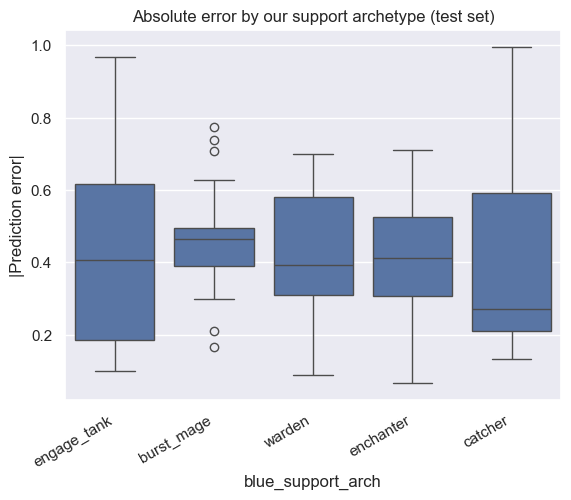

In [9]:
support_meta = []
for m in matches:
    blue_support_arch = assignments.get(m["blue_team"]["Support"], {}).get("primary_archetype", "unknown")
    red_support_arch = assignments.get(m["red_team"]["Support"], {}).get("primary_archetype", "unknown")
    support_meta.append({
        "blue_support_arch": blue_support_arch,
        "red_support_arch": red_support_arch,
        "blue_engage": 1 if blue_support_arch == "engage_tank" else 0,
        "red_engage": 1 if red_support_arch == "engage_tank" else 0,
    })
support_meta_df = pd.DataFrame(support_meta)

residual_df = pd.DataFrame({
    "match_index": idx_test,
    "pred_prob": baseline_test_proba,
    "actual": y_test,
})
residual_df = residual_df.join(support_meta_df.iloc[idx_test].reset_index(drop=True))
residual_df["residual"] = residual_df["actual"] - residual_df["pred_prob"]
residual_df["abs_error"] = residual_df["residual"].abs()
residual_df["engage_diff"] = residual_df["blue_engage"] - residual_df["red_engage"]

support_gap_summary = residual_df.groupby("engage_diff").agg(
    count=("actual", "size"),
    mean_abs_error=("abs_error", "mean"),
    mean_pred=("pred_prob", "mean"),
    win_rate=("actual", "mean"),
)
print("Residual summary by engage diff (blue engage - red engage):")
print(support_gap_summary)

resid_model = smf.ols(
    "abs_error ~ engage_diff + C(blue_support_arch) + C(red_support_arch)",
    data=residual_df
).fit(cov_type="HC3")
print(resid_model.summary().tables[1])

top_supports = residual_df["blue_support_arch"].value_counts().head(5).index
sns.boxplot(
    data=residual_df[residual_df["blue_support_arch"].isin(top_supports)],
    x="blue_support_arch",
    y="abs_error",
)
plt.xticks(rotation=30, ha="right")
plt.ylabel("|Prediction error|")
plt.title("Absolute error by our support archetype (test set)")
plt.show()


## 8. Validation Checklist & Next Actions
Distill the quantitative checkpoints (accuracy, calibration, bias tests) into a compact table for reporting and surface any remaining work.

In [10]:
logistic_ci_row = ci_df[ci_df["model"] == "Scaled Logistic"].iloc[0]
gb_ci_row = ci_df[ci_df["model"] == "Gradient Boosting"].iloc[0]
cal_ci_row = ci_df[ci_df["model"] == "Calibrated GB"].iloc[0]

summary_rows = [
    {
        "model": "Scaled Logistic",
        "val_acc": baseline_metrics["val_acc"],
        "test_acc": baseline_metrics["test_acc"],
        "ci_low": logistic_ci_row["ci_low"],
        "ci_high": logistic_ci_row["ci_high"],
        "meets_55@85": logistic_ci_row["ci_low"] >= 0.55,
    },
    {
        "model": "Gradient Boosting",
        "val_acc": advanced_metrics["val_acc"],
        "test_acc": advanced_metrics["test_acc"],
        "ci_low": gb_ci_row["ci_low"],
        "ci_high": gb_ci_row["ci_high"],
        "meets_55@85": gb_ci_row["ci_low"] >= 0.55,
    },
    {
        "model": "Calibrated GB",
        "val_acc": np.nan,
        "test_acc": cal_ci_row["accuracy"],
        "ci_low": cal_ci_row["ci_low"],
        "ci_high": cal_ci_row["ci_high"],
        "meets_55@85": cal_ci_row["ci_low"] >= 0.55,
    },
]
summary_df = pd.DataFrame(summary_rows)
print("Model accuracy + 85% CI summary:")
print(summary_df)

logistic_high_conf = high_conf_df[(high_conf_df["model"] == "Logistic") & (high_conf_df["cutoff"] == 0.55)]
if not logistic_high_conf.empty:
    row = logistic_high_conf.iloc[0]
    print(
        f"Logistic ≥55% confidence subset: accuracy={row['subset_accuracy']:.3f} over {int(row['count'])} samples (coverage={row['coverage']*100:.1f}%)."
    )

bias_band = archetype_effects["delta_vs_engage_pp"].agg(["min", "max"])
print(
    f"Archetype deltas vs engage tank span {bias_band['min']:.3f} to {bias_band['max']:.3f} percentage points after controls."
)

pending_actions = {
    "Need_more_data": int(len(matches) < 8000),
    "Transformer_checkpoint": "not yet implemented",
    "Calibration_status": "GB calibrated via isotonic on train+val",
}
pending_actions


Model accuracy + 85% CI summary:
               model   val_acc  test_acc    ci_low   ci_high  meets_55@85
0    Scaled Logistic  0.638298  0.652482  0.592923  0.707624         True
1  Gradient Boosting  0.659574  0.609929  0.549613  0.667061        False
2      Calibrated GB       NaN  0.595745  0.535281  0.653435        False
Logistic ≥55% confidence subset: accuracy=0.659 over 123 samples (coverage=87.2%).
Archetype deltas vs engage tank span -0.341 to 11.686 percentage points after controls.


{'Need_more_data': 1,
 'Transformer_checkpoint': 'not yet implemented',
 'Calibration_status': 'GB calibrated via isotonic on train+val'}